## Импорт библиотек

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import sqrt

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb

## Анализ данных

In [101]:
data = pd.read_csv("insurance.csv")
print(data.shape)
data.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [155]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [103]:
#how many nulls
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [137]:
data.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [138]:
data.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [139]:
data.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [140]:
data.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

## Визуализация данных

Рассмотрим распределение charges, а также значения charges в зависимости от категорий признаков.

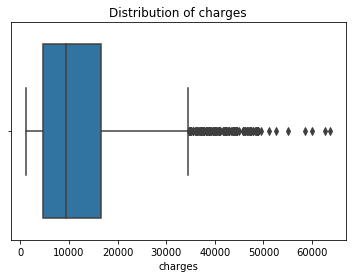

In [210]:
sns.set_context({"figure.figsize":(6,4)})
sns.boxplot(data.charges)
plt.title('Distribution of charges');

Посмотрим, влияет ли курение на показатели charges.

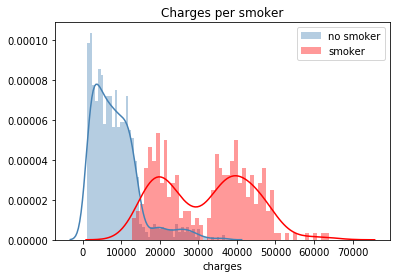

In [211]:
sns.distplot(data[data['smoker'] == 'no']["charges"], color="steelblue", label="no smoker", bins=50)
# 2-я категория 
sns.distplot(data[data['smoker'] == "yes"]["charges"], color="red", label="smoker", bins=50)
plt.legend()
plt.title('Charges per smoker');

На данном графике видно, что charges зависит от того, является человек курящим или нет.

Рассмотрим теперь распределение charges по регонам.

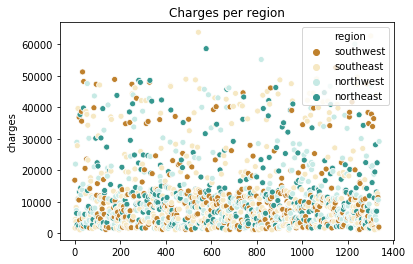

In [212]:
sns.scatterplot(data.index, data.charges, data = data, hue = data.region, palette = 'BrBG')
plt.title('Charges per region');

Что же касается влияния региона на charges, то из приведенного графика следует, что нет каких-то явных отличий между регионами. 

In [247]:
ddd = data.groupby(['sex'])['charges'].mean()
ddd

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

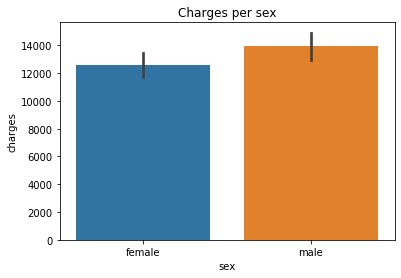

In [213]:
sns.barplot(data.sex, data.charges)
plt.title('Charges per sex');

На графике выше мужской пол преобладает по показателю среднего значения charges.

Перейдем к возрасту.

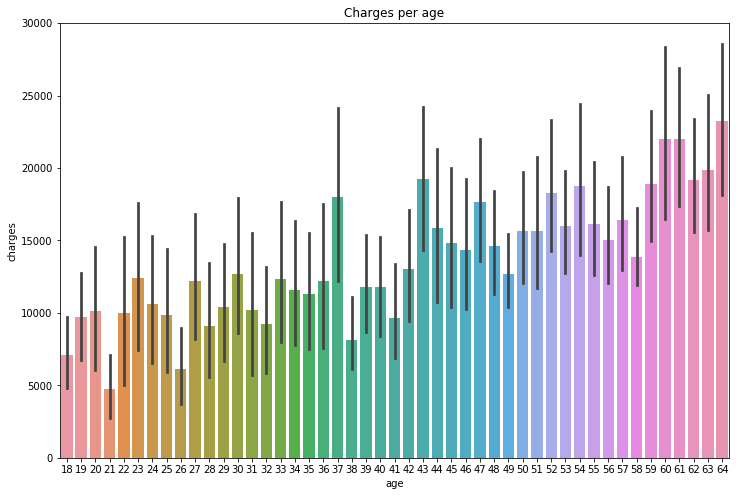

In [214]:
sns.set_context({"figure.figsize":(12,8)})
sns.barplot(data.age, data.charges)
plt.title('Charges per age');

Можно сдлеать вывод, чем больше возраст, тем больше значения charges.

Преимущество по среднему значению charges имеют люди с количеством детей равным 3. По этому показателю значительно уступают с количеством детей равным 5. 

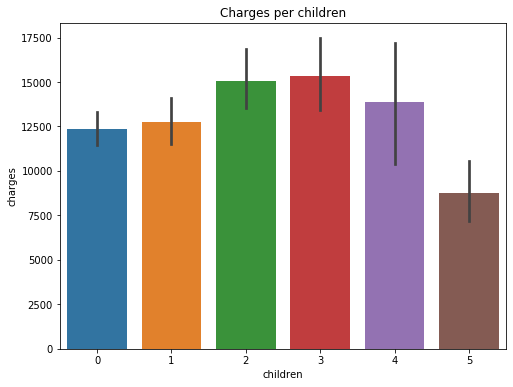

In [215]:
sns.set_context({"figure.figsize":(8,6)})
sns.barplot(data.children, data.charges)
plt.title('Charges per children');

## Подготовка данных

Для дальнейшего использования моделей для предсказания, необходимо категориальные признаки кодировать. 

In [104]:
df = data.copy()
for feature in ['sex', 'smoker', 'region']:
    df[feature] = pd.Categorical(df[feature]).codes

In [105]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Проверим правильность кодирования

In [164]:
df.region.value_counts()

2    364
3    325
1    325
0    324
Name: region, dtype: int64

Если же немного вернуться к визуализации данных, то можно построить график корреляции между признаками (приведен ниже). Данный график подтверждает выводы, сделанные ранее. Наибольшую корреляцию имеют признаки charges и smoker.

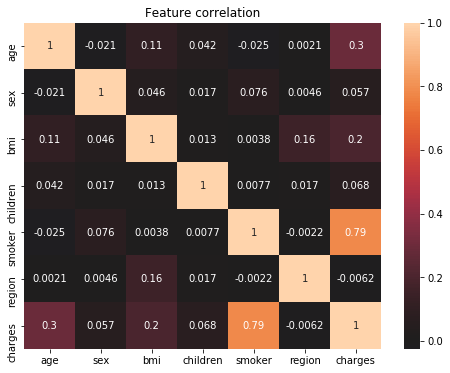

In [252]:
df_corr = df.corr()
sns.heatmap(df_corr, xticklabels=df_corr.columns, yticklabels=df_corr.columns, center=0, annot=True)
plt.title('Feature correlation');

Разделим датасет на признаки, которыми мы будем руководствоваться для прогнозирования, и на признак, который и необходимо предсказать.

In [110]:
X = df.iloc[0:len(df), 0:6]
Y = pd.DataFrame(df.iloc[0:len(df), 6]) 

In [111]:
labels = np.array(df['charges'])
feature_list = list(X.columns)
features = np.array(X)

Разделение датасета на обучающую и тестовую выборки. 70 (training) и 30 (testing)

In [112]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=42)

# check the size of the samples
print('Training Features Shape:' + str(train_features.shape))
print('Training Labels Shape:' + str(train_labels.shape))
print('Testing Features Shape:' + str(test_features.shape))
print('Testing Labels Shape:' + str(test_labels.shape))

Training Features Shape:(936, 6)
Training Labels Shape:(936,)
Testing Features Shape:(402, 6)
Testing Labels Shape:(402,)


## Применение моделей предсказания

Для сравнения оценки работы моделей были выбраны следующие модели
- RandomForestRegressor, 
- GradientBoostingRegressor, 
- CatBoostRegressor,
- XGBRegressor.

В качетве метрик оценки работы моделей выбраны
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* R2 (R-squared)
* MAPE (Mean Absolute Percentage Error) 

### RandomForestRegressor

In [113]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [114]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [181]:
mae_rf = mean_absolute_error(test_labels, predictions)
rmse_rf = sqrt(mean_squared_error(test_labels, predictions))
r2_rf = r2_score(test_labels, predictions)

errors_rf = abs(predictions - test_labels)

# Calculate mean absolute percentage error (MAPE)
mape_rf = 100 * (errors_rf / test_labels)

# Calculate and display accuracy
accuracy_rf = 100 - np.mean(mape_rf)

In [183]:
print("MAE: ", mae_rf.astype("int"))
print("RMSE: ", int(rmse_rf))
print("R2: ", round(r2_rf, 2))
print("Accuracy: ", round(accuracy_rf, 2), "%")

MAE:  2527
RMSE:  4597
R2:  0.86
Accuracy:  69.9 %


### GradientBoostingRegressor

In [116]:
regressor = GradientBoostingRegressor(
    max_depth=4,
    n_estimators=4,
    learning_rate=1.0
)
regressor.fit(train_features, train_labels)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [117]:
pred_gr = regressor.predict(test_features)
mae_gr = mean_absolute_error(test_labels, pred_gr)
rmse_gr = sqrt(mean_squared_error(test_labels, pred_gr))
r2_gr = r2_score(test_labels, pred_gr)

In [186]:
errors_gr = abs(pred_gr - test_labels)
mape_gr = 100 * (errors_gr / test_labels)
accuracy_gr = 100 - np.mean(mape_gr)

In [187]:
print("MAE: ", mae_gr.astype("int"))
print("RMSE: ", int(rmse_gr))
print("R2: ", round(r2_gr, 2))
print("Accuracy: ", round(accuracy_gr, 2), "%")

MAE:  2689
RMSE:  4643
R2:  0.85
Accuracy:  68.82 %


### CatBoostRegressor

In [302]:
model_cat = CatBoostRegressor(iterations=50, depth=5, learning_rate=0.1, loss_function='RMSE')
model_cat.fit(train_features, train_labels)

0:	learn: 11268.3912790	total: 363ms	remaining: 17.8s
1:	learn: 10435.9962855	total: 406ms	remaining: 9.74s
2:	learn: 9714.5035284	total: 415ms	remaining: 6.51s
3:	learn: 9126.2203917	total: 417ms	remaining: 4.79s
4:	learn: 8616.4139582	total: 418ms	remaining: 3.76s
5:	learn: 8118.8597796	total: 419ms	remaining: 3.07s
6:	learn: 7637.0448829	total: 420ms	remaining: 2.58s
7:	learn: 7197.7037766	total: 420ms	remaining: 2.21s
8:	learn: 6866.6460780	total: 421ms	remaining: 1.92s
9:	learn: 6548.7858615	total: 422ms	remaining: 1.69s
10:	learn: 6279.0855017	total: 424ms	remaining: 1.5s
11:	learn: 6064.8627560	total: 424ms	remaining: 1.34s
12:	learn: 5832.7565343	total: 426ms	remaining: 1.21s
13:	learn: 5655.6944029	total: 426ms	remaining: 1.1s
14:	learn: 5488.2987466	total: 427ms	remaining: 997ms
15:	learn: 5351.3909264	total: 434ms	remaining: 923ms
16:	learn: 5209.1907878	total: 435ms	remaining: 845ms
17:	learn: 5104.4387886	total: 436ms	remaining: 775ms
18:	learn: 5015.0473312	total: 437ms	r

In [120]:
pred_cat = model_cat.predict(test_features)
mae_cat = mean_absolute_error(test_labels, pred_cat)
rmse_cat = sqrt(mean_squared_error(test_labels, pred_cat))
r2_cat = r2_score(test_labels, pred_cat)

In [188]:
errors_cat = abs(pred_cat - test_labels)
mape_cat = 100 * (errors_cat / test_labels)
accuracy_cat = 100 - np.mean(mape_cat)

In [189]:
print("MAE: ", mae_cat.astype("int"))
print("RMSE: ", int(rmse_cat))
print("R2: ", round(r2_cat, 2))
print("Accuracy: ", round(accuracy_cat, 2), "%")

MAE:  2443
RMSE:  4266
R2:  0.88
Accuracy:  68.12 %


### XGBRegressor

In [176]:
xgbr = xgb.XGBRegressor() 
xgbr.fit(train_features, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [127]:
pred_xgbr = xgbr.predict(test_features)
mae_xgbr = mean_absolute_error(test_labels, pred_xgbr)
rmse_xgbr = sqrt(mean_squared_error(test_labels, pred_xgbr))
r2_xgbr = r2_score(test_labels, pred_xgbr)

In [190]:
errors_xgbr = abs(pred_xgbr - test_labels)
mape_xgbr = 100 * (errors_xgbr / test_labels)
accuracy_xgbr = 100 - np.mean(mape_xgbr)

In [191]:
print("MAE: ", mae_xgbr.astype("int"))
print("RMSE: ", int(rmse_xgbr))
print("R2: ", round(r2_xgbr, 2))
print("Accuracy: ", round(accuracy_xgbr, 2), "%")

MAE:  2873
RMSE:  5149
R2:  0.82
Accuracy:  61.25 %


## Сравнение моделей

In [202]:
metrics = pd.DataFrame({
    "algorithm": ['RandomForest', 'GradientBoosting', 'CatBoost', 'XGB'],
    "mae_value": [mae_rf, mae_gr, mae_cat, mae_xgbr],
    "rmse_value": [rmse_rf, rmse_gr, rmse_cat, rmse_xgbr],
    "r2_value": [r2_rf, r2_gr, r2_cat, r2_xgbr],
    "accuracy": [accuracy_rf, accuracy_gr, accuracy_cat, accuracy_xgbr]
})
metrics.mae_value = metrics.mae_value.astype('int')
metrics.rmse_value = metrics.rmse_value.astype('int')
metrics.accuracy = round(metrics.accuracy, 2)
metrics

,algorithm,mae_value,rmse_value,r2_value,accuracy
0,RandomForest,2527,4597,0.855838,69.90
1,GradientBoosting,2689,4643,0.852926,68.82
2,CatBoost,2443,4266,0.875840,68.12
3,XGB,2873,5149,0.819162,61.25


Визуализация значений метрик

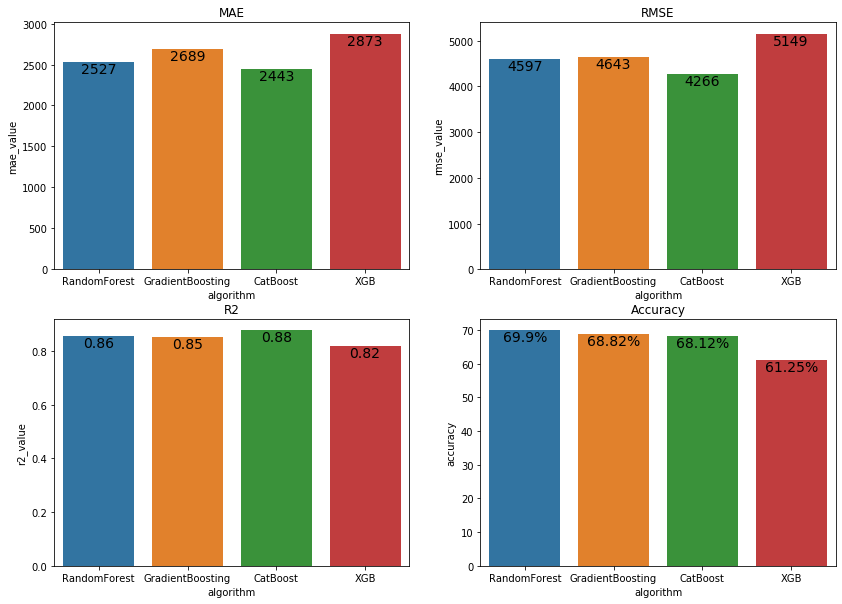

In [227]:
f, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)

a1 = sns.barplot(data=metrics, y='mae_value', x='algorithm', ax=axes[0, 0])
for i, f in enumerate(metrics.mae_value):
    a1.text(i, f, round(f, 0), horizontalalignment='center', verticalalignment='top', fontdict={'fontweight':500, 'size':14})
a1.set_title("MAE")

a2 = sns.barplot(data=metrics, y='rmse_value', x='algorithm', ax=axes[0, 1])
for i, f in enumerate(metrics.rmse_value):
    a2.text(i, f, round(f, 0), horizontalalignment='center', verticalalignment='top', fontdict={'fontweight':500, 'size':14})
a2.set_title("RMSE")

a3 = sns.barplot(data=metrics, y='r2_value', x='algorithm', ax=axes[1, 0])
for i, f in enumerate(metrics.r2_value):
    a3.text(i, f, round(f, 2), horizontalalignment='center', verticalalignment='top', fontdict={'fontweight':500, 'size':14})
a3.set_title("R2")

a4 = sns.barplot(data=metrics, y='accuracy', x='algorithm', ax=axes[1, 1])
for i, f in enumerate(metrics.accuracy):
    a4.text(i, f, str(round(f, 2))+"%", horizontalalignment='center', 
             verticalalignment='top', fontdict={'fontweight':500, 'size':14})
a4.set_title("Accuracy");

На графиках выше можно заметить, что по метрикам MAE, RMSE, R2 лучшей моделью является CatBoostRegressor. Что же касается accuracy, то CatBoostRegressor немного уступает моделям RandomForest и GradientBossting. 

Можно сделать вывод, что для данного датасета наилучшим образом подходит модель CatBoostRegressor. 

Далее весь анализ проводится с использованием результатов модели CatBoostRegerssor.

## Feature importance

In [132]:
# Get numerical feature importances
importances = list(model_cat.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 1)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
feat_imp = pd.DataFrame(feature_importances, columns = ['variable', 'importance'])
feat_imp

,variable,importance
0,smoker,75.6
1,bmi,13.0
2,age,9.0
3,children,1.1
4,region,0.8
5,sex,0.5


Проиллюстрируем полученные значения важности признаков.

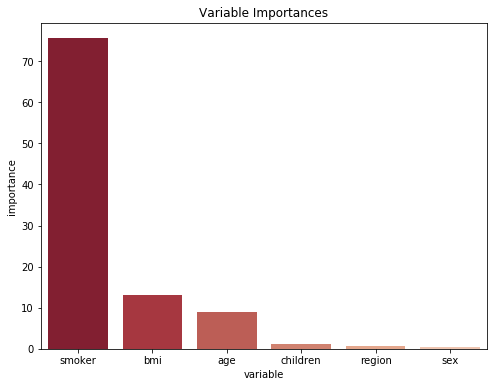

In [254]:
sns.barplot(feat_imp.variable, feat_imp.importance, orientation = 'vertical', palette= sns.color_palette("RdGy", 16))
plt.title('Variable Importances');

Из полученного графика следует,  что наибольшую важность имеет такой признак, как ***smoker***. Это говорит нам о том, что лучшим предиктом для charges является показатель курения. На втором месте находится ***bmi***. И на третьем - ***age***. 

## Результат предсказания charges

Теперь посмотрим на визуализацию сравнения тестовых и предсказанных значений.

In [135]:
ddf = pd.DataFrame({'Actual': test_labels, 'Predicted': pred_cat})
ddf

,Actual,Predicted
0,9095.06825,9763.161699
1,5272.17580,6221.004462
2,29330.98315,26415.344842
3,9301.89355,9462.947611
4,33750.29180,34594.428397
...,...,...
397,9541.69555,12212.546465
398,4399.73100,6242.151443
399,2200.83085,4047.405335
400,11363.28320,13383.259110


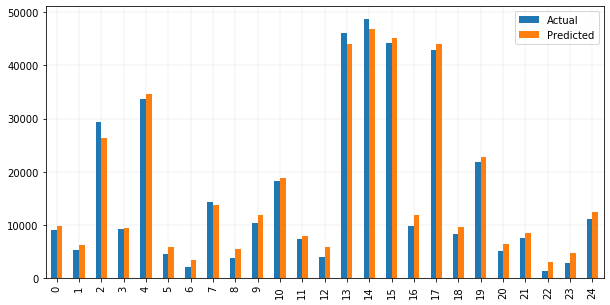

In [136]:
df1 = ddf.head(25)
df1.plot(kind='bar',figsize=(10, 5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

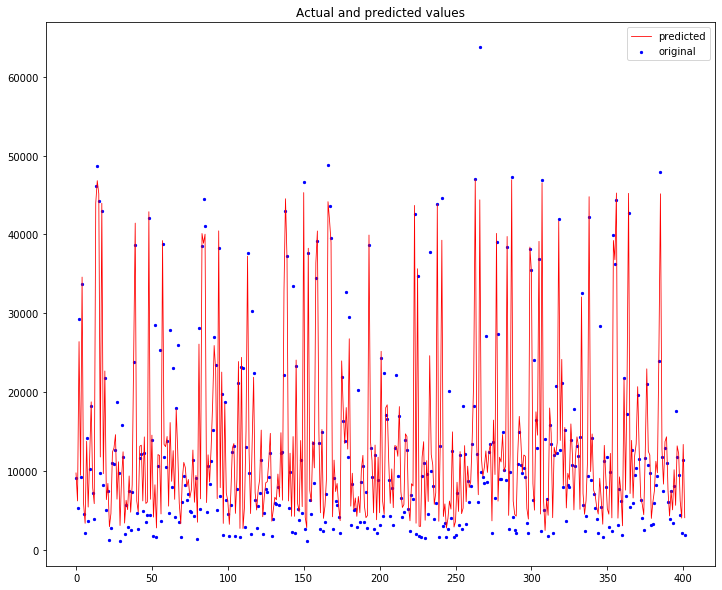

In [255]:
x_ax = range(len(test_labels))

sns.set_context({"figure.figsize":(12,10)})

plt.scatter(x_ax, test_labels, s=5, color="blue", label="original")
plt.plot(x_ax, pred_cat, lw=0.8, color="red", label="predicted")
plt.title('Actual and predicted values')
plt.legend()
plt.show()

Сравнение изначальных данных и данных с предсказанными значениями.

In [334]:
pred_cat = pd.DataFrame(pred_cat)
train_labels = pd.DataFrame(train_labels)

df_y_pred = pd.concat([train_labels, pred_cat], ignore_index = True)
df['Y_pred'] = df_y_pred

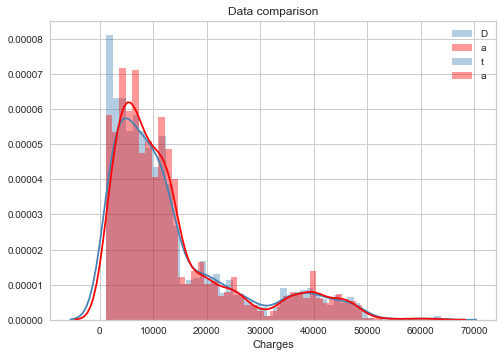

In [337]:
sns.distplot(df["charges"], color="steelblue", label = "Original", bins=50)
sns.distplot(df["Y_pred"], color="red", label = "Predicted", bins=50)
plt.legend("Data")
plt.xlabel("Charges")
plt.title('Data comparison');